# Brent Oil Price Prediction with LSTM Model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils.vis_utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.7.0
Num GPUs Available:  0


## Reading dataset

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(8864, 2)

Note the date gaps.

## Drop negative prices if any

In [3]:
indexNames = df[df['Price'] < 0].index
df.drop(indexNames , inplace=True)
df.shape

(8864, 2)

## Filling date gaps

For market closed dates, use the previous date's price.

In [4]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.shape

(12753, 2)

In [5]:
df.tail()

,Date,Price
Date,,
2022-04-14,2022-04-14,110.83
2022-04-15,2022-04-15,110.83
2022-04-16,2022-04-16,110.83
2022-04-17,2022-04-17,110.83
2022-04-18,2022-04-18,110.83


## Preparing the time series dataset

In [6]:
time_step = [i for i in range(df.shape[0])]
series = np.array(df[['Price']])
time = np.array(time_step)

## Functions

In [7]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Visualizing the time series dataset

Text(0.5, 1.0, 'Brent Oil Price')

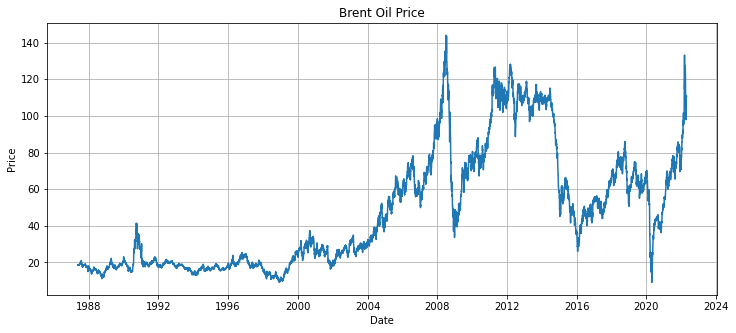

In [10]:
plt.figure(figsize=(12, 5))
plot_series(df['Date'], df['Price'])
plt.title('Brent Oil Price')

## Spliting the dataset for training and validation

In [11]:
split_time = 11500
time_train = time[:split_time]
x_train = series[:split_time]
x_label_train = df[['Date']][:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]
x_label_valid = df[['Date']][split_time:]

## Hyperparameters

In [12]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
epochs = 400
n_input = 365
n_features = 1

## Tuning the learning rate

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                      strides = 1, padding = "causal",
                      activation = "relu",
                      input_shape = [None, 1]),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.LSTM(64, return_sequences = True),
  tf.keras.layers.Dense(30, activation = "relu"),
  tf.keras.layers.Dense(10, activation = "relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-8, momentum = 0.9)
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ["mae"])
history_tune = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(11500, 1)
Epoch 1/100
45/45 [==============================] - 7s 119ms/step - loss: 48.5430 - mae: 49.0429
Epoch 2/100
45/45 [==============================] - 5s 109ms/step - loss: 37.4642 - mae: 37.9603
Epoch 3/100
45/45 [==============================] - 5s 107ms/step - loss: 32.0064 - mae: 32.4913
Epoch 4/100
45/45 [==============================] - 5s 110ms/step - loss: 29.5851 - mae: 30.0707
Epoch 5/100
45/45 [==============================] - 5s 107ms/step - loss: 27.5611 - mae: 28.0454
Epoch 6/100
45/45 [==============================] - 5s 108ms/step - loss: 25.4049 - mae: 25.8867
Epoch 7/100
45/45 [==============================] - 5s 109ms/step - loss: 23.0225 - mae: 23.5016
Epoch 8/100
45/45 [==============================] - 5s 107ms/step - loss: 20.5401 - mae: 21.0160
Epoch 9/100
45/45 [==============================] - 5s 107ms/step - loss: 18.1595 - mae: 18.6313
Epoch 1

45/45 [==============================] - 5s 113ms/step - loss: 22.4397 - mae: 22.9339
Epoch 84/100
45/45 [==============================] - 5s 109ms/step - loss: 28.5622 - mae: 29.0593
Epoch 85/100
45/45 [==============================] - 5s 111ms/step - loss: 22.2256 - mae: 22.7214
Epoch 86/100
45/45 [==============================] - 5s 113ms/step - loss: 35.3908 - mae: 35.8890
Epoch 87/100
45/45 [==============================] - 5s 112ms/step - loss: 28.7637 - mae: 29.2621
Epoch 88/100
45/45 [==============================] - 5s 108ms/step - loss: 30.0262 - mae: 30.5238
Epoch 89/100
45/45 [==============================] - 5s 111ms/step - loss: 37.5013 - mae: 38.0001
Epoch 90/100
45/45 [==============================] - 5s 107ms/step - loss: 60.5150 - mae: 61.0140
Epoch 91/100
45/45 [==============================] - 5s 106ms/step - loss: 51.6911 - mae: 52.1893
Epoch 92/100
45/45 [==============================] - 6s 135ms/step - loss: 47.5969 - mae: 48.0952
Epoch 93/100
45/45 [===

In [14]:
min_loss = min(history_tune.history["loss"])
print(f'min_loss: {min_loss}')
index = np.argmin(history_tune.history["loss"])
learning_rate = history_tune.history["lr"][index]
print(f'learning_rate: {learning_rate}')

min_loss: 2.402961254119873
learning_rate: 3.5481339182297233e-06


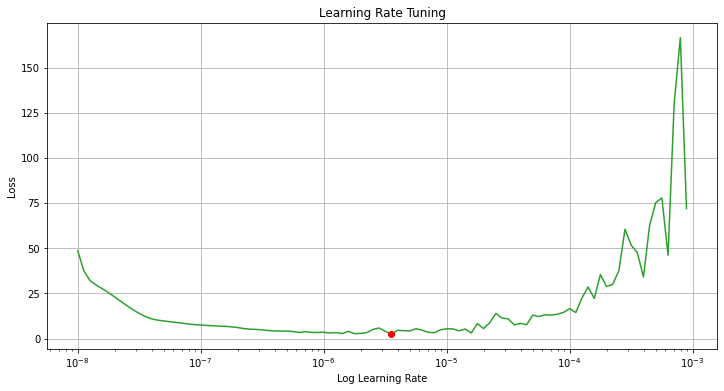

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history_tune.history['lr'], history_tune.history['loss'], color="C2")
plt.plot(learning_rate, min_loss, 'ro')    
plt.xlabel('Log Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()

## Training the model

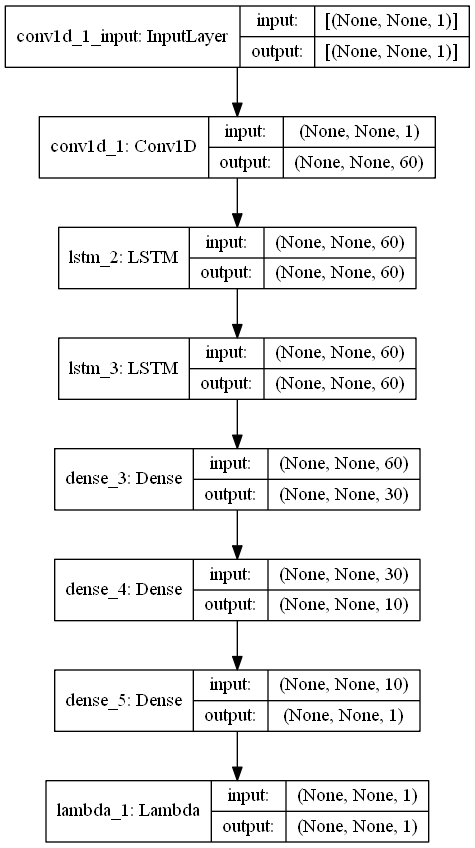

In [16]:
def build_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                          strides = 1, padding = "causal",
                          activation = "relu",
                          input_shape = [None, 1]),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.LSTM(60, return_sequences = True),
      tf.keras.layers.Dense(30, activation = "relu"),
      tf.keras.layers.Dense(10, activation = "relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
    model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ["mae"])
    return model

model = build_model()
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [17]:
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
history_train = model.fit(train_set, epochs = epochs, validation_data = valid_set)

Epoch 1/400
45/45 [==============================] - 7s 123ms/step - loss: 17.9431 - mae: 18.4361 - val_loss: 5.6470 - val_mae: 6.1233
Epoch 2/400
45/45 [==============================] - 5s 115ms/step - loss: 4.7998 - mae: 5.2764 - val_loss: 3.9500 - val_mae: 4.4220
Epoch 3/400
45/45 [==============================] - 5s 120ms/step - loss: 4.2921 - mae: 4.7674 - val_loss: 3.8488 - val_mae: 4.3154
Epoch 4/400
45/45 [==============================] - 6s 122ms/step - loss: 4.8304 - mae: 5.2949 - val_loss: 6.1960 - val_mae: 6.6818
Epoch 5/400
45/45 [==============================] - 6s 121ms/step - loss: 7.4777 - mae: 7.9652 - val_loss: 3.7551 - val_mae: 4.2310
Epoch 6/400
45/45 [==============================] - 6s 122ms/step - loss: 3.9677 - mae: 4.4259 - val_loss: 6.7175 - val_mae: 7.2157
Epoch 7/400
45/45 [==============================] - 6s 124ms/step - loss: 2.3335 - mae: 2.7837 - val_loss: 2.2163 - val_mae: 2.6660
Epoch 8/400
45/45 [==============================] - 5s 118ms/step 

45/45 [==============================] - 6s 124ms/step - loss: 2.0631 - mae: 2.5252 - val_loss: 1.1396 - val_mae: 1.5548
Epoch 63/400
45/45 [==============================] - 6s 125ms/step - loss: 1.2328 - mae: 1.6812 - val_loss: 1.1136 - val_mae: 1.5395
Epoch 64/400
45/45 [==============================] - 5s 120ms/step - loss: 0.6314 - mae: 0.9732 - val_loss: 1.3455 - val_mae: 1.7867
Epoch 65/400
45/45 [==============================] - 6s 121ms/step - loss: 1.0677 - mae: 1.5060 - val_loss: 1.0508 - val_mae: 1.4681
Epoch 66/400
45/45 [==============================] - 5s 120ms/step - loss: 1.6252 - mae: 2.0930 - val_loss: 0.9861 - val_mae: 1.3906
Epoch 67/400
45/45 [==============================] - 6s 122ms/step - loss: 1.0866 - mae: 1.5202 - val_loss: 1.1166 - val_mae: 1.5319
Epoch 68/400
45/45 [==============================] - 6s 123ms/step - loss: 1.9947 - mae: 2.4613 - val_loss: 1.4043 - val_mae: 1.8489
Epoch 69/400
45/45 [==============================] - 6s 123ms/step - loss:

45/45 [==============================] - 6s 121ms/step - loss: 1.1856 - mae: 1.6263 - val_loss: 0.9021 - val_mae: 1.2980
Epoch 124/400
45/45 [==============================] - 5s 120ms/step - loss: 0.6659 - mae: 1.0590 - val_loss: 0.8768 - val_mae: 1.2742
Epoch 125/400
45/45 [==============================] - 6s 124ms/step - loss: 0.7096 - mae: 1.1134 - val_loss: 0.9085 - val_mae: 1.3089
Epoch 126/400
45/45 [==============================] - 6s 125ms/step - loss: 0.5897 - mae: 0.9667 - val_loss: 0.8058 - val_mae: 1.1780
Epoch 127/400
45/45 [==============================] - 6s 123ms/step - loss: 0.5304 - mae: 0.8735 - val_loss: 0.8512 - val_mae: 1.2460
Epoch 128/400
45/45 [==============================] - 5s 120ms/step - loss: 0.7962 - mae: 1.2161 - val_loss: 0.8454 - val_mae: 1.2257
Epoch 129/400
45/45 [==============================] - 6s 123ms/step - loss: 0.7532 - mae: 1.1485 - val_loss: 0.8511 - val_mae: 1.2382
Epoch 130/400
45/45 [==============================] - 6s 121ms/step 

Epoch 184/400
45/45 [==============================] - 6s 124ms/step - loss: 0.4895 - mae: 0.8480 - val_loss: 0.7459 - val_mae: 1.1119
Epoch 185/400
45/45 [==============================] - 6s 122ms/step - loss: 0.5194 - mae: 0.8898 - val_loss: 0.7440 - val_mae: 1.1103
Epoch 186/400
45/45 [==============================] - 6s 124ms/step - loss: 0.4553 - mae: 0.7740 - val_loss: 0.9143 - val_mae: 1.3335
Epoch 187/400
45/45 [==============================] - 6s 123ms/step - loss: 0.4526 - mae: 0.7711 - val_loss: 0.7679 - val_mae: 1.1442
Epoch 188/400
45/45 [==============================] - 6s 123ms/step - loss: 0.5719 - mae: 0.9582 - val_loss: 0.9641 - val_mae: 1.3955
Epoch 189/400
45/45 [==============================] - 5s 120ms/step - loss: 0.4805 - mae: 0.8207 - val_loss: 0.8708 - val_mae: 1.2820
Epoch 190/400
45/45 [==============================] - 6s 122ms/step - loss: 0.6612 - mae: 1.0713 - val_loss: 0.7451 - val_mae: 1.1137
Epoch 191/400
45/45 [==============================] - 

Epoch 245/400
45/45 [==============================] - 6s 124ms/step - loss: 0.4529 - mae: 0.7756 - val_loss: 0.7392 - val_mae: 1.1133
Epoch 246/400
45/45 [==============================] - 6s 125ms/step - loss: 0.4486 - mae: 0.7960 - val_loss: 0.7976 - val_mae: 1.1941
Epoch 247/400
45/45 [==============================] - 6s 122ms/step - loss: 0.5415 - mae: 0.9224 - val_loss: 0.7023 - val_mae: 1.0631
Epoch 248/400
45/45 [==============================] - 6s 124ms/step - loss: 0.4460 - mae: 0.7827 - val_loss: 0.8164 - val_mae: 1.2174
Epoch 249/400
45/45 [==============================] - 6s 125ms/step - loss: 0.4516 - mae: 0.7751 - val_loss: 0.8536 - val_mae: 1.2658
Epoch 250/400
45/45 [==============================] - 6s 123ms/step - loss: 0.6114 - mae: 1.0182 - val_loss: 0.8221 - val_mae: 1.2250
Epoch 251/400
45/45 [==============================] - 6s 124ms/step - loss: 0.5860 - mae: 0.9867 - val_loss: 0.8002 - val_mae: 1.1998
Epoch 252/400
45/45 [==============================] - 

Epoch 306/400
45/45 [==============================] - 6s 124ms/step - loss: 0.4157 - mae: 0.7261 - val_loss: 0.6917 - val_mae: 1.0508
Epoch 307/400
45/45 [==============================] - 6s 121ms/step - loss: 0.4623 - mae: 0.8060 - val_loss: 0.6808 - val_mae: 1.0322
Epoch 308/400
45/45 [==============================] - 6s 122ms/step - loss: 0.4409 - mae: 0.7916 - val_loss: 0.8009 - val_mae: 1.2051
Epoch 309/400
45/45 [==============================] - 6s 122ms/step - loss: 0.3948 - mae: 0.7252 - val_loss: 0.7057 - val_mae: 1.0745
Epoch 310/400
45/45 [==============================] - 6s 123ms/step - loss: 0.5174 - mae: 0.8846 - val_loss: 0.6761 - val_mae: 1.0288
Epoch 311/400
45/45 [==============================] - 6s 121ms/step - loss: 0.4529 - mae: 0.8056 - val_loss: 0.7666 - val_mae: 1.1533
Epoch 312/400
45/45 [==============================] - 6s 123ms/step - loss: 0.5195 - mae: 0.9096 - val_loss: 0.7482 - val_mae: 1.1342
Epoch 313/400
45/45 [==============================] - 

Epoch 367/400
45/45 [==============================] - 6s 122ms/step - loss: 0.4355 - mae: 0.7697 - val_loss: 0.6635 - val_mae: 1.0153
Epoch 368/400
45/45 [==============================] - 5s 119ms/step - loss: 0.4853 - mae: 0.8558 - val_loss: 0.7421 - val_mae: 1.1249
Epoch 369/400
45/45 [==============================] - 6s 122ms/step - loss: 0.4574 - mae: 0.8242 - val_loss: 0.6689 - val_mae: 1.0220
Epoch 370/400
45/45 [==============================] - 5s 120ms/step - loss: 0.3691 - mae: 0.6780 - val_loss: 0.7504 - val_mae: 1.1480
Epoch 371/400
45/45 [==============================] - 5s 120ms/step - loss: 0.4430 - mae: 0.8002 - val_loss: 0.6962 - val_mae: 1.0717
Epoch 372/400
45/45 [==============================] - 6s 121ms/step - loss: 0.4561 - mae: 0.8150 - val_loss: 0.6624 - val_mae: 1.0206
Epoch 373/400
45/45 [==============================] - 5s 120ms/step - loss: 0.4530 - mae: 0.8088 - val_loss: 0.8094 - val_mae: 1.2155
Epoch 374/400
45/45 [==============================] - 

## Forcasting

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Text(0.5, 1.0, 'Forcasting')

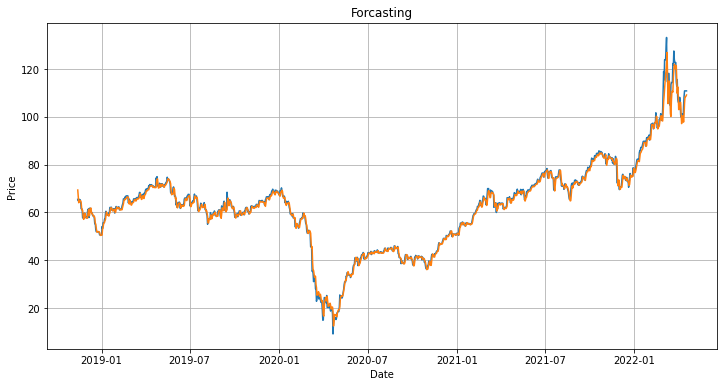

In [19]:
plt.figure(figsize=(12, 6))
plot_series(x_label_valid['Date'], x_valid)
plot_series(x_label_valid['Date'], rnn_forecast)
plt.title('Forcasting')

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([13.470352 , 13.3817215, 13.500211 , ..., 48.876534 , 48.876534 ,
       48.876534 ], dtype=float32)

In [21]:
zoom_begin = epochs - 50
zoon_end = epochs + 1
x_last = list(range(zoom_begin, zoon_end))

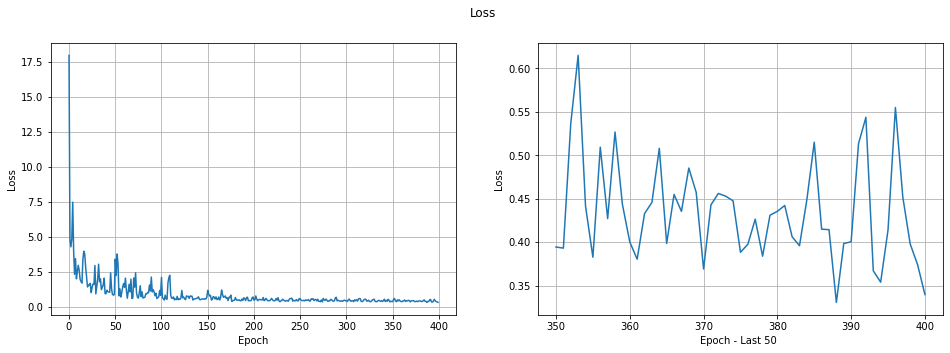

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Loss')
ax1.plot(range(0, epochs), history_train.history["loss"])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax2.plot(x_last, history_train.history["loss"][zoom_begin - 1:])
ax2.set_xlabel('Epoch - Last 50 ')
ax2.set_ylabel('Loss')
ax2.grid(True)

## Final training and saving

In [23]:
# The final model will be trained on the entire dataset
full_set = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
final_model = build_model()
history_final = final_model.fit(full_set, epochs = epochs)
final_model.save('model')

Epoch 1/400
50/50 [==============================] - 7s 112ms/step - loss: 22.4711 - mae: 22.9652
Epoch 2/400
50/50 [==============================] - 6s 124ms/step - loss: 8.3045 - mae: 8.7883
Epoch 3/400
50/50 [==============================] - 6s 116ms/step - loss: 5.5635 - mae: 6.0430
Epoch 4/400
50/50 [==============================] - 6s 123ms/step - loss: 5.9961 - mae: 6.4751
Epoch 5/400
50/50 [==============================] - 6s 120ms/step - loss: 3.8394 - mae: 4.2968
Epoch 6/400
50/50 [==============================] - 6s 123ms/step - loss: 6.6023 - mae: 7.0892
Epoch 7/400
50/50 [==============================] - 6s 118ms/step - loss: 4.3676 - mae: 4.8422
Epoch 8/400
50/50 [==============================] - 6s 120ms/step - loss: 7.7097 - mae: 8.1970
Epoch 9/400
50/50 [==============================] - 6s 118ms/step - loss: 5.5547 - mae: 6.0348
Epoch 10/400
50/50 [==============================] - 6s 120ms/step - loss: 3.8371 - mae: 4.3066
Epoch 11/400
50/50 [=================

50/50 [==============================] - 6s 121ms/step - loss: 1.5875 - mae: 2.0407
Epoch 86/400
50/50 [==============================] - 6s 122ms/step - loss: 1.7076 - mae: 2.1645
Epoch 87/400
50/50 [==============================] - 6s 120ms/step - loss: 0.6880 - mae: 1.0805
Epoch 88/400
50/50 [==============================] - 6s 121ms/step - loss: 0.8457 - mae: 1.2497
Epoch 89/400
50/50 [==============================] - 6s 122ms/step - loss: 1.0641 - mae: 1.5025
Epoch 90/400
50/50 [==============================] - 6s 124ms/step - loss: 1.0973 - mae: 1.5372
Epoch 91/400
50/50 [==============================] - 6s 121ms/step - loss: 0.5961 - mae: 0.9554
Epoch 92/400
50/50 [==============================] - 6s 122ms/step - loss: 0.6041 - mae: 0.9362
Epoch 93/400
50/50 [==============================] - 6s 120ms/step - loss: 0.6607 - mae: 1.0252
Epoch 94/400
50/50 [==============================] - 6s 123ms/step - loss: 0.6941 - mae: 1.0785
Epoch 95/400
50/50 [=======================

50/50 [==============================] - 6s 123ms/step - loss: 0.8750 - mae: 1.2966
Epoch 169/400
50/50 [==============================] - 6s 118ms/step - loss: 0.7215 - mae: 1.1199
Epoch 170/400
50/50 [==============================] - 6s 122ms/step - loss: 0.8430 - mae: 1.2733
Epoch 171/400
50/50 [==============================] - 6s 119ms/step - loss: 0.6107 - mae: 0.9731
Epoch 172/400
50/50 [==============================] - 6s 122ms/step - loss: 0.7532 - mae: 1.1699
Epoch 173/400
50/50 [==============================] - 6s 120ms/step - loss: 0.5184 - mae: 0.8363
Epoch 174/400
50/50 [==============================] - 6s 121ms/step - loss: 0.5180 - mae: 0.8715
Epoch 175/400
50/50 [==============================] - 6s 120ms/step - loss: 0.6882 - mae: 1.0949
Epoch 176/400
50/50 [==============================] - 6s 121ms/step - loss: 0.5022 - mae: 0.8156
Epoch 177/400
50/50 [==============================] - 6s 120ms/step - loss: 0.5223 - mae: 0.8451
Epoch 178/400
50/50 [=============

50/50 [==============================] - 6s 119ms/step - loss: 0.5264 - mae: 0.8566
Epoch 252/400
50/50 [==============================] - 6s 121ms/step - loss: 0.6091 - mae: 0.9813
Epoch 253/400
50/50 [==============================] - 6s 120ms/step - loss: 0.6951 - mae: 1.0908
Epoch 254/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4890 - mae: 0.8257
Epoch 255/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4693 - mae: 0.7915
Epoch 256/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4704 - mae: 0.7785
Epoch 257/400
50/50 [==============================] - 6s 119ms/step - loss: 0.4646 - mae: 0.7829
Epoch 258/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4558 - mae: 0.7780
Epoch 259/400
50/50 [==============================] - 6s 119ms/step - loss: 0.4784 - mae: 0.8164
Epoch 260/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4492 - mae: 0.7614
Epoch 261/400
50/50 [=============

50/50 [==============================] - 6s 122ms/step - loss: 0.5427 - mae: 0.9245
Epoch 335/400
50/50 [==============================] - 6s 121ms/step - loss: 0.4818 - mae: 0.7918
Epoch 336/400
50/50 [==============================] - 6s 123ms/step - loss: 0.4775 - mae: 0.8130
Epoch 337/400
50/50 [==============================] - 6s 121ms/step - loss: 0.5594 - mae: 0.9382
Epoch 338/400
50/50 [==============================] - 6s 122ms/step - loss: 0.4486 - mae: 0.7593
Epoch 339/400
50/50 [==============================] - 6s 120ms/step - loss: 0.4480 - mae: 0.7853
Epoch 340/400
50/50 [==============================] - 6s 122ms/step - loss: 0.4281 - mae: 0.7467
Epoch 341/400
50/50 [==============================] - 6s 120ms/step - loss: 0.4945 - mae: 0.8101
Epoch 342/400
50/50 [==============================] - 6s 122ms/step - loss: 0.5734 - mae: 0.9280
Epoch 343/400
50/50 [==============================] - 6s 121ms/step - loss: 0.6278 - mae: 1.0234
Epoch 344/400
50/50 [=============

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
